In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")
warnings.warn("this will not show")

plt.rcParams["figure.figsize"] = (10,6)

sns.set_style("whitegrid")
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Set it None to display all rows in the dataframe
pd.set_option('display.max_rows', None)

# Set it to None to display all columns in the dataframe
pd.set_option('display.max_columns', None)

In [2]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, average_precision_score
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import GridSearchCV

### #Random Forest Classifier

In [3]:
df1 = pd.read_csv("dataset.csv")
df1.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,work_accident,left,promotion_last_5years,departments,salary
0,0.380,0.530,2,157,3,0,1,0,sales,low
1,0.800,0.860,5,262,6,0,1,0,sales,medium
2,0.110,0.880,7,272,4,0,1,0,sales,medium
3,0.720,0.870,5,223,5,0,1,0,sales,low
4,0.370,0.520,2,159,3,0,1,0,sales,low


In [4]:
df1.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,work_accident,left,promotion_last_5years,departments,salary
0,0.380,0.530,2,157,3,0,1,0,sales,low
1,0.800,0.860,5,262,6,0,1,0,sales,medium
2,0.110,0.880,7,272,4,0,1,0,sales,medium
3,0.720,0.870,5,223,5,0,1,0,sales,low
4,0.370,0.520,2,159,3,0,1,0,sales,low


#### Model Building

In [5]:
df_rfc = df1.copy()

In [6]:
df_rfc.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,work_accident,left,promotion_last_5years,departments,salary
0,0.380,0.530,2,157,3,0,1,0,sales,low
1,0.800,0.860,5,262,6,0,1,0,sales,medium
2,0.110,0.880,7,272,4,0,1,0,sales,medium
3,0.720,0.870,5,223,5,0,1,0,sales,low
4,0.370,0.520,2,159,3,0,1,0,sales,low


In [7]:
df_rfc.shape

(11991, 10)

In [8]:
df_rfc.isnull().sum().sum()

0

#### Modeling with Pipeline

#### Train | Test Split

In [9]:
X = df_rfc.drop(columns="left")
y = df_rfc['left']

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
cat = X_train.select_dtypes("object").columns
cat

Index(['departments', 'salary'], dtype='object')

In [12]:
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OrdinalEncoder


ord_enc = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

column_trans = make_column_transformer((ord_enc, cat), remainder='passthrough')

In [13]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

operations = [("OrdinalEncoder", column_trans), ("RF_model", RandomForestClassifier(random_state=42))]

pipe_model = Pipeline(steps=operations)

pipe_model.fit(X_train, y_train)

Pipeline(steps=[('OrdinalEncoder',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ordinalencoder',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  Index(['departments', 'salary'], dtype='object'))])),
                ('RF_model', RandomForestClassifier(random_state=42))])

#### Model Performance on Classification Tasks

In [14]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, recall_score, precision_score,f1_score

def eval_metric(model, X_train, y_train, X_test, y_test):
    y_train_pred = model.predict(X_train)
    y_pred = model.predict(X_test)
    
    print("Test_Set")
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    print()
    print("Train_Set")
    print(confusion_matrix(y_train, y_train_pred))
    print(classification_report(y_train, y_train_pred))

#### Random Forest

In [15]:
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_validate, cross_val_score
from sklearn.model_selection import GridSearchCV

In [16]:
eval_metric(pipe_model, X_train, y_train, X_test, y_test)

Test_Set
[[1991    7]
 [  39  362]]
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1998
           1       0.98      0.90      0.94       401

    accuracy                           0.98      2399
   macro avg       0.98      0.95      0.96      2399
weighted avg       0.98      0.98      0.98      2399


Train_Set
[[8002    0]
 [   0 1590]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      8002
           1       1.00      1.00      1.00      1590

    accuracy                           1.00      9592
   macro avg       1.00      1.00      1.00      9592
weighted avg       1.00      1.00      1.00      9592



In [17]:
operations = [("OrdinalEncoder", column_trans), ("RF_model", RandomForestClassifier(random_state=42))]   # CV

model = Pipeline(steps=operations)

scores = cross_validate(model, X_train, y_train, scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc'], 
                        cv = 10)
df_scores = pd.DataFrame(scores, index = range(1, 11))
df_scores.mean()[2:]

test_accuracy    0.986
test_precision   0.991
test_recall      0.924
test_f1          0.956
test_roc_auc     0.980
dtype: float64

#### Evaluating ROC Curves and AUC

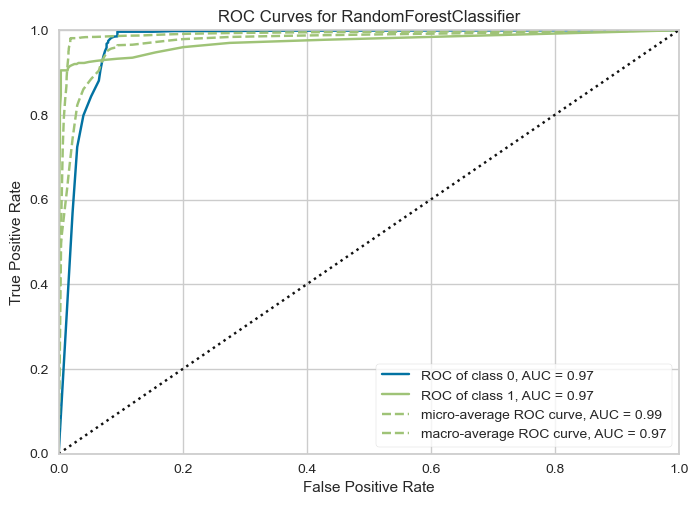

In [18]:
from yellowbrick.classifier import ROCAUC

model = pipe_model
visualizer = ROCAUC(model)

visualizer.fit(X_train, y_train)        # Fit the training data to the visualizer
visualizer.score(X_test, y_test)        # Evaluate the model on the test data
visualizer.show();                       # Finalize and render the figure

#### RF Model Feature Importance

In [19]:
pipe_model["RF_model"].feature_importances_

array([0.01177983, 0.00747471, 0.35505924, 0.12330774, 0.18349599,
       0.14995656, 0.16386347, 0.00427224, 0.00079021])

In [20]:
X_train.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,work_accident,promotion_last_5years,departments,salary
6417,0.860,0.560,5,141,2,0,0,sales,medium
288,0.820,0.910,5,232,5,0,0,technical,low
5042,0.620,0.520,3,148,3,0,0,sales,medium
11123,0.430,0.740,4,129,6,0,0,hr,medium
3678,0.850,0.790,3,156,3,0,0,sales,medium


In [21]:
X_train.select_dtypes("object").columns

Index(['departments', 'salary'], dtype='object')

In [22]:
features = list(X_train.select_dtypes("object").columns) + list(X_train.select_dtypes("number").columns)
features

['departments',
 'salary',
 'satisfaction_level',
 'last_evaluation',
 'number_project',
 'average_montly_hours',
 'time_spend_company',
 'work_accident',
 'promotion_last_5years']

In [23]:
rf_feature_imp = pd.DataFrame(data = pipe_model["RF_model"].feature_importances_, index = features, 
                              columns = ["Feature Importance"]).sort_values("Feature Importance", ascending = False)
rf_feature_imp

,Feature Importance
satisfaction_level,0.355
number_project,0.183
time_spend_company,0.164
average_montly_hours,0.150
last_evaluation,0.123
departments,0.012
salary,0.007
work_accident,0.004
promotion_last_5years,0.001


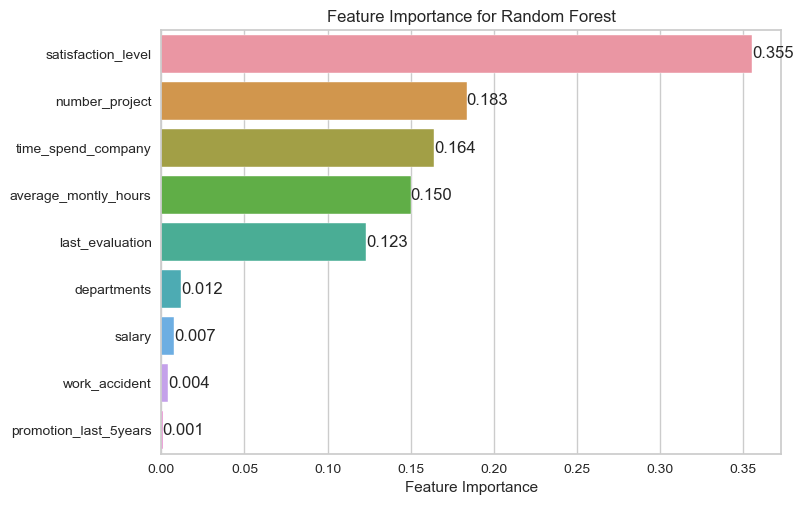

In [24]:
ax = sns.barplot(x=rf_feature_imp["Feature Importance"], y=rf_feature_imp.index)
ax.bar_label(ax.containers[0],fmt="%.3f")
plt.title("Feature Importance for Random Forest")
plt.show()

#### Understanding Hyperparameters

#### Find Best Parameters

In [25]:
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.pipeline import Pipeline

In [26]:
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier

In [27]:
operations = [("OrdinalEncoder", column_trans), ("RF_model", RandomForestClassifier(random_state=42))]

pipe_model = Pipeline(steps=operations)

In [28]:
param_grid = { 
    'RF_model__n_estimators': [50, 100, 150, 200],
    'RF_model__max_features': [3, 5, 'auto'],
    'RF_model__max_depth' : [10,12,15,20],      # en üst değer 8 olarak vermiştim. o çıkınca tekrar düzenledim. üst değer 10 verdim. Onu da seçti, yükselttim.
    'RF_model__class_weight': [None, 'balanced']
}

In [29]:
rf_grid_model = GridSearchCV(estimator=pipe_model,
                          param_grid=param_grid,
                          scoring='f1',   
                          cv=10,
                          #verbose=1,
                          n_jobs = -1)

In [30]:
rf_grid_model.fit(X_train, y_train)  

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('OrdinalEncoder',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ordinalencoder',
                                                                         OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                        unknown_value=-1),
                                                                         Index(['departments', 'salary'], dtype='object'))])),
                                       ('RF_model',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'RF_model__class_weight': [None, 'balanced'],
                         'RF_model__max_depth': [10, 12, 15, 20],
                         'RF_model__max_features': [3, 5, 'auto'],
                         'RF_model__n_estimators': [50, 100, 150, 200]},
             scoring='f1')

In [31]:
print('\n', rf_grid_model.best_params_)
print('\n', rf_grid_model.best_estimator_)
print('\n', 'Best Score :', rf_grid_model.best_score_)    #modeli collab ta çalıştırdım. skorları oradan aldım.


 {'RF_model__class_weight': None, 'RF_model__max_depth': 12, 'RF_model__max_features': 3, 'RF_model__n_estimators': 200}

 Pipeline(steps=[('OrdinalEncoder',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ordinalencoder',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  Index(['departments', 'salary'], dtype='object'))])),
                ('RF_model',
                 RandomForestClassifier(max_depth=12, max_features=3,
                                        n_estimators=200, random_state=42))])

 Best Score : 0.9566632930129971


In [32]:
eval_metric(rf_grid_model, X_train, y_train, X_test, y_test)

Test_Set
[[1991    7]
 [  40  361]]
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1998
           1       0.98      0.90      0.94       401

    accuracy                           0.98      2399
   macro avg       0.98      0.95      0.96      2399
weighted avg       0.98      0.98      0.98      2399


Train_Set
[[7995    7]
 [  77 1513]]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      8002
           1       1.00      0.95      0.97      1590

    accuracy                           0.99      9592
   macro avg       0.99      0.98      0.98      9592
weighted avg       0.99      0.99      0.99      9592



#### Evaluating Model Performance and Tuning

In [33]:
from sklearn.metrics import precision_recall_curve, plot_precision_recall_curve, plot_roc_curve, roc_auc_score, roc_curve,\
                            average_precision_score

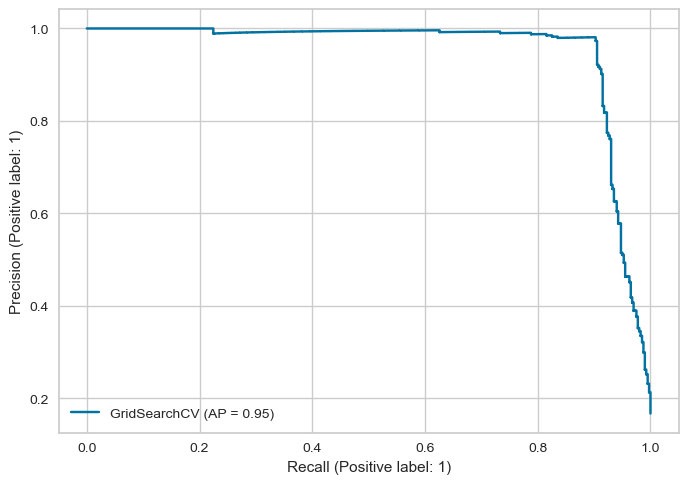

In [34]:
plot_precision_recall_curve(rf_grid_model, X_test, y_test);

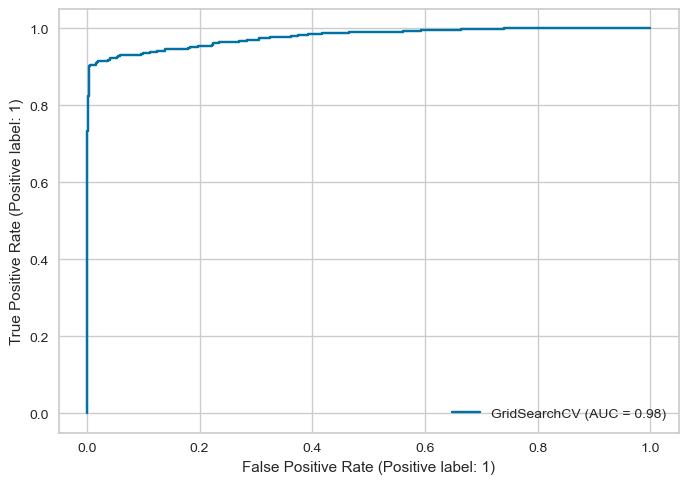

In [35]:
plot_roc_curve(rf_grid_model, X_test, y_test);

In [36]:
operations = [("OrdinalEncoder", column_trans), ("grid2_model", RandomForestClassifier(max_depth=12, max_features=3,
                                                                         n_estimators=200, random_state=42))]

rf_grid2_model = Pipeline(steps=operations)

rf_grid2_model.fit(X_train, y_train)

Pipeline(steps=[('OrdinalEncoder',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ordinalencoder',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  Index(['departments', 'salary'], dtype='object'))])),
                ('grid2_model',
                 RandomForestClassifier(max_depth=12, max_features=3,
                                        n_estimators=200, random_state=42))])

In [37]:
eval_metric(rf_grid2_model, X_train, y_train, X_test, y_test)

Test_Set
[[1991    7]
 [  40  361]]
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1998
           1       0.98      0.90      0.94       401

    accuracy                           0.98      2399
   macro avg       0.98      0.95      0.96      2399
weighted avg       0.98      0.98      0.98      2399


Train_Set
[[7995    7]
 [  77 1513]]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      8002
           1       1.00      0.95      0.97      1590

    accuracy                           0.99      9592
   macro avg       0.99      0.98      0.98      9592
weighted avg       0.99      0.99      0.99      9592



In [38]:
rf_grid2_model['grid2_model'].feature_importances_

array([0.00834359, 0.00614396, 0.35866804, 0.1160106 , 0.18599539,
       0.15135117, 0.16871646, 0.00418514, 0.00058564])

In [39]:
features = list(X_train.select_dtypes("object").columns) + list(X_train.select_dtypes("number").columns)
features

['departments',
 'salary',
 'satisfaction_level',
 'last_evaluation',
 'number_project',
 'average_montly_hours',
 'time_spend_company',
 'work_accident',
 'promotion_last_5years']

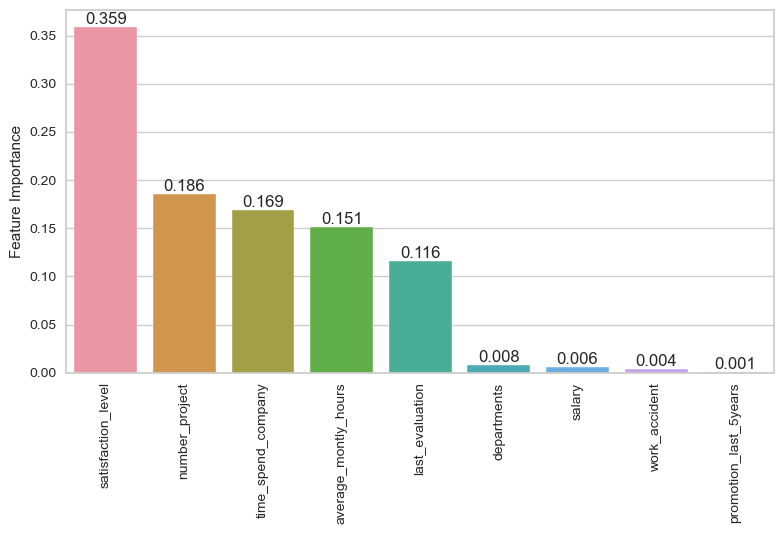

In [40]:
df_f_i = pd.DataFrame(data = rf_grid2_model["grid2_model"].feature_importances_, index=features, #index=X.columns
                      columns = ["Feature Importance"]).sort_values("Feature Importance", ascending=False)




ax = sns.barplot(x = df_f_i.index, y = 'Feature Importance', data = df_f_i)
ax.bar_label(ax.containers[0],fmt="%.3f");
plt.xticks(rotation = 90)
plt.tight_layout()

In [41]:
X.head(1)

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,work_accident,promotion_last_5years,departments,salary
0,0.380,0.530,2,157,3,0,0,sales,low


In [42]:
X2 = X.drop(columns = ["promotion_last_5years","departments","salary","work_accident"])

In [43]:
cat2 = X2.select_dtypes("object").columns
cat2

Index([], dtype='object')

In [44]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y, test_size=0.2, random_state=42)

In [45]:
column_trans2 = make_column_transformer((OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value = -1), cat2), 
                                       remainder="passthrough")

In [46]:
X_train2.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company
6417,0.860,0.560,5,141,2
288,0.820,0.910,5,232,5
5042,0.620,0.520,3,148,3
11123,0.430,0.740,4,129,6
3678,0.850,0.790,3,156,3


In [47]:
operations2 = [("grid2_model", RandomForestClassifier(max_depth=12, max_features=3,
                                                                         n_estimators=200, random_state=42))]

pipe_model2 = Pipeline(steps = operations2)

pipe_model2.fit(X_train2, y_train2)

Pipeline(steps=[('grid2_model',
                 RandomForestClassifier(max_depth=12, max_features=3,
                                        n_estimators=200, random_state=42))])

In [48]:
eval_metric(pipe_model2, X_train2, y_train2, X_test2, y_test2)

Test_Set
[[1990    8]
 [  39  362]]
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1998
           1       0.98      0.90      0.94       401

    accuracy                           0.98      2399
   macro avg       0.98      0.95      0.96      2399
weighted avg       0.98      0.98      0.98      2399


Train_Set
[[7996    6]
 [  70 1520]]
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      8002
           1       1.00      0.96      0.98      1590

    accuracy                           0.99      9592
   macro avg       0.99      0.98      0.99      9592
weighted avg       0.99      0.99      0.99      9592



In [49]:
operations = [("OrdinalEncoder", column_trans), ("RF_model", RandomForestClassifier(max_depth=12, max_features=3,
                                                                         n_estimators=200, random_state=42))]

pipe_model_pkl = Pipeline(steps=operations)

In [50]:
pipe_model_pkl.fit(X,y)

Pipeline(steps=[('OrdinalEncoder',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ordinalencoder',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  Index(['departments', 'salary'], dtype='object'))])),
                ('RF_model',
                 RandomForestClassifier(max_depth=12, max_features=3,
                                        n_estimators=200, random_state=42))])

#### Save and Export the Model as .pkl

In [51]:
import pickle

In [52]:
operations = [("grid2_model", RandomForestClassifier(max_depth=12, max_features=3,
                                                                         n_estimators=200, random_state=42))]

pickle_model = Pipeline(steps = operations)

pickle_model.fit(X2, y)

Pipeline(steps=[('grid2_model',
                 RandomForestClassifier(max_depth=12, max_features=3,
                                        n_estimators=200, random_state=42))])

In [53]:
pickle.dump(pickle_model, open('pickle_model', 'wb'))

In [54]:
pickle_model = pickle.load(open("pickle_model", "rb"))

#### Prediction

In [55]:
X2.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company
0,0.380,0.530,2,157,3
1,0.800,0.860,5,262,6
2,0.110,0.880,7,272,4
3,0.720,0.870,5,223,5
4,0.370,0.520,2,159,3


In [56]:
# Prediction 
a = pd.DataFrame({
        'satisfaction_level': 0.3,
        'last_evaluation': 0.6,
        'number_project': 7,
        'average_montly_hours': 215,
        'time_spend_company': 4
    }, index=[0])

In [57]:
prediction_a = pickle_model.predict(a)
prediction_a  

array([1], dtype=int64)

In [58]:
# Prediction 
b = pd.DataFrame({
        'satisfaction_level': 0.21,
        'last_evaluation': 0.79,
        'number_project': 4,
        'average_montly_hours': 134,
        'time_spend_company': 4
    }, index=[0])

In [59]:
prediction_b = pickle_model.predict(b)
prediction_b  

array([0], dtype=int64)